# Visualize sample methylation matrix with PCA

This notebook is for visualizing methylation matrices and their deconvolution results

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!conda info | grep 'active env'

     active environment : 2023_06_26_SRT_deconvolution_MS
    active env location : /home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS


In [2]:
def create_pc_dict(num):
    return {i: f"PC{i+1}" for i in range(num)}

def difference(listA, listB):
    return list(set(listA).difference(set(listB)))

In [35]:
sns.set_context('talk')

## Data preprocessing

In [3]:
# load data
# 1648 regions for each 127 samples = 209296 rows
data = pd.read_csv('../output/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz',sep='\t')
sample_df = pd.read_csv('../stage/metadata/samples_wgbs.20230329.tsv',sep='\t')
metadata = sample_df[['sample_id','sample_group', 'age']] \
    .rename({'sample_id':'SAMPLE_ID'},axis=1) \
    .drop_duplicates()

# blueprint cell type x immune regions reference matrix
refmat = pd.read_csv('../output/deconv_inhouse_v2.atlas.tsv.gz',sep='\t')

# merge donor sex into metadata
blueprint_df = pd.read_csv('../stage/metadata/20160816.data.index.tsv',sep='\t')\
                    .drop_duplicates('SAMPLE_ID')
metadata = pd.merge(metadata, blueprint_df[['SAMPLE_ID','DONOR_SEX']], on ='SAMPLE_ID') \
    .rename({'DONOR_SEX':'sex'},axis=1)

In [4]:
# 23 samples are in the blueprint metadata, but not in sample_df metadata.
A = data.sample_id.unique()
B = list(sample_df.sample_id)
diff_id_list = difference(A, B)

# 23 in sample_df missing metadata
# print(len(diff_id_list))

In [5]:
'''
Should expect 127 samples total if True.
Should expect 104 samples total if False.

23 samples are in the blueprint metadata, but not in 
sample_df metadata. I use the CELL_TYPE feature in the 
blueprint data to get cell type info (instead of sample_group).
This seems to be more detailed than sample_group.
'''
INCLUDE_23 = False

if INCLUDE_23:
    filtered_blueprint_df = blueprint_df[blueprint_df['SAMPLE_ID'].isin(diff_id_list)]
    filtered_blueprint_df = filtered_blueprint_df[['SAMPLE_ID', 'CELL_TYPE', 'DONOR_AGE', 'DONOR_SEX']]\
                                .rename({'CELL_TYPE':'sample_group'}, axis=1)\
                                .rename({'DONOR_AGE':'age'}, axis=1)\
                                .rename({'DONOR_SEX':'sex'}, axis=1)
    print(filtered_blueprint_df.sample_group.unique())

    metadata = pd.concat([metadata, filtered_blueprint_df], axis=0)

metadata.shape

(104, 4)

In [6]:
metadata.head()

,SAMPLE_ID,sample_group,age,sex
0,ERS433785,Umbilical-Endothelium,0 - 5,Male
1,ERS433789,Umbilical-Endothelium,0 - 5,Male
2,ERS433796,Umbilical-Endothelium,0 - 5,Female
3,ERS433793,Umbilical-Endothelium,0 - 5,Female
4,ERS661049,Blueprint-Neutro,65 - 70,Male


## Run PCA on reference regions

In [21]:
N_PCA = 4

# Only look at regions in the ref matrix (blueprint immune cell type specific)
idxs = data['region_id'].isin(refmat['region_id'])
data = data[idxs]

# Run PCA
X =  data[['sample_id','region_id','frac_alpha_leq_25pct']] \
    .pivot_table(index='region_id',columns=['sample_id'],values='frac_alpha_leq_25pct') \
    .transpose() 

samples = X.index.values
X = X.to_numpy()
X[np.isnan(X)] = 0

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=N_PCA)
result = pca.fit(X)
pca_df = pd.DataFrame(result.transform(X))

pca_df = pca_df \
    .rename(create_pc_dict(N_PCA),axis=1) \
     .assign(SAMPLE_ID=samples) \
     .merge(metadata, how='inner')

In [95]:
X.shape

(127, 280)

In [22]:
print(pca_df.shape)
pca_df.head()

(104, 8)


,PC1,PC2,PC3,PC4,SAMPLE_ID,sample_group,age,sex
0,-14.293443,5.480963,-1.943376,0.600059,ERS1022343,Blueprint-B,60 - 65,Female
1,0.662924,-2.267095,2.094057,-1.214323,ERS1138462,Blueprint-Mono,40 - 45,Male
2,0.880085,-2.110544,2.392476,-1.009068,ERS1138463,Blueprint-Mono,65 - 70,Female
3,1.480446,-5.616048,7.955626,-4.223285,ERS206483,Blueprint-Neutro,0 - 5,Female
4,0.712375,-2.436782,2.357701,-1.217027,ERS206500,Blueprint-Mono,60 - 65,Female


## PCs colored by cell type

In [23]:
# sns.scatterplot(x="PC1",y="PC2",hue="sample_group",data=pca_df)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True, shadow=True)

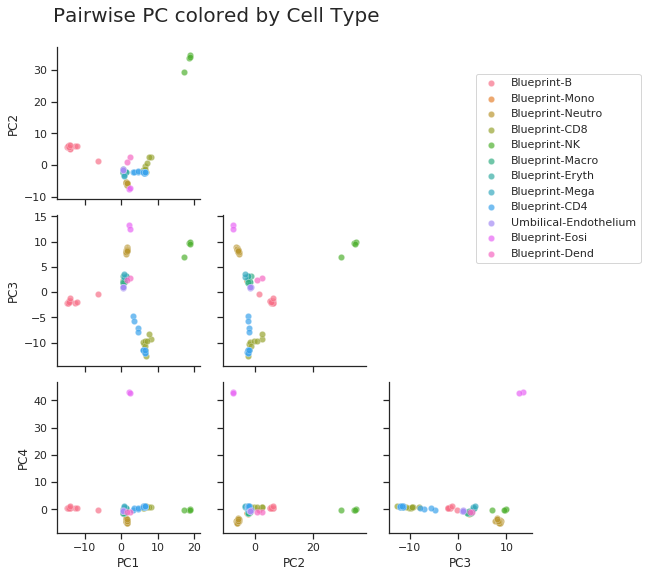

In [90]:
g = sns.PairGrid(pca_df, hue='sample_group')
g.map_lower(plt.scatter, s=40, edgecolor='white', linewidth=.3, alpha=0.7)
g.fig.suptitle("Pairwise PC colored by Cell Type", size=20, x=0.3, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)
plt.legend(loc='lower right', bbox_to_anchor=(1.80, 1.75))
plt.show()

In [94]:
np.round(pca.explained_variance_ratio_, 2)

array([0.2 , 0.18, 0.15, 0.12])

## PCs colored by age

In [37]:
# all age range
metadata.age.unique()

array(['0 - 5', '65 - 70', '80 - 85', '70 - 75', '20 - 30', '40 - 45',
       '35 - 40', '50 - 55', '60 - 65', '55 - 60', '20 - 40', '45 - 50',
       '30 - 35', '25 - 30'], dtype=object)

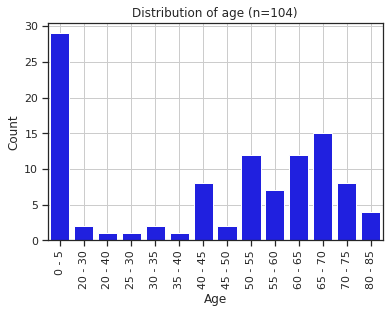

In [64]:
# barplot of age
counts = pca_df.age.value_counts()
age_order = ['0 - 5', '20 - 30', '20 - 40', '25 - 30', 
             '30 - 35', '35 - 40', '40 - 45', '45 - 50', 
             '50 - 55', '55 - 60', '60 - 65', '65 - 70', 
             '70 - 75', '80 - 85']
counts = counts.loc[age_order]


sns.set(style="ticks")
sns.barplot(x=counts.index, y=counts.values, color='blue')
plt.title('Distribution of age (n=104)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid()
plt.show()

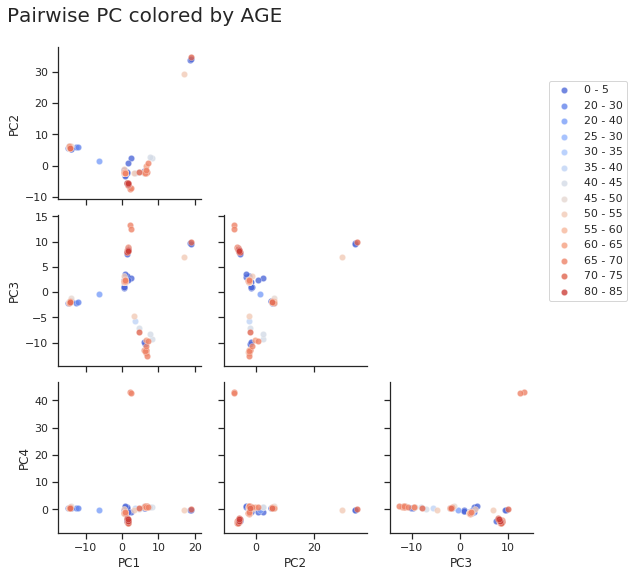

In [89]:
g = sns.PairGrid(pca_df, hue='age', palette='coolwarm', hue_order=age_order)
g.map_lower(plt.scatter, s=40, edgecolor='white', linewidth=.3, alpha=0.8)
g.fig.suptitle("Pairwise PC colored by AGE", size=20, x=0.2, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)

# plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, fancybox=True, shadow=True)
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, 5), ncol=1, fancybox=True, shadow=True)
plt.legend(loc='lower right', bbox_to_anchor=(1.70, 1.5))
plt.show()

## PCs colored by sex

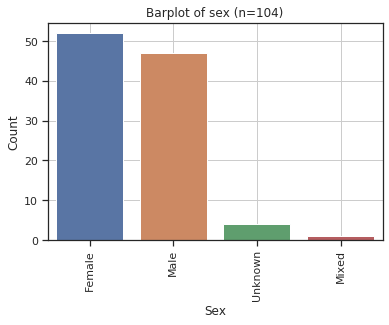

In [40]:
# barplot of age
counts = pca_df.sex.value_counts()

sns.set(style="ticks")
sns.barplot(x=counts.index, y=counts.values)
plt.title('Barplot of sex (n=104)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid()
plt.show()

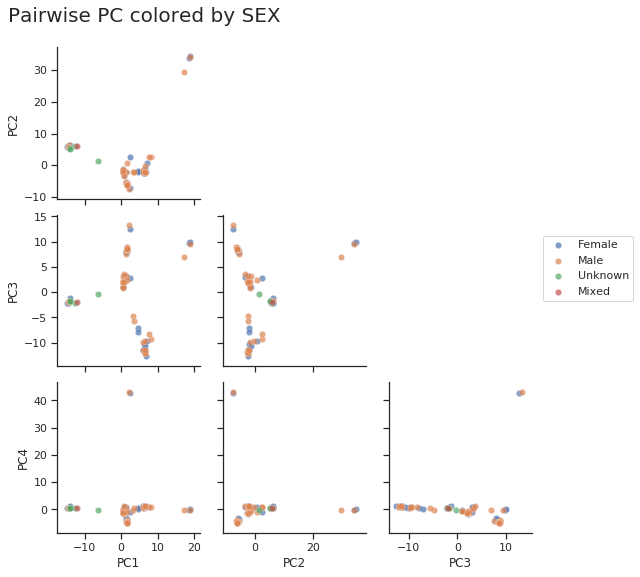

In [91]:
g = sns.PairGrid(pca_df, hue='sex')
g.map_lower(plt.scatter, s=40, edgecolor='white', linewidth=.3, alpha=0.7)
g.fig.suptitle("Pairwise PC colored by SEX", size=20, x=0.2, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)

# plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, fancybox=True, shadow=True)
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, 5), ncol=1, fancybox=True, shadow=True)
plt.legend(loc='lower right', bbox_to_anchor=(1.75, 1.5))
plt.show()

### Reference region hypo-methylation distribution

In [42]:
data.region_id

0             Immune_Broad_Neutro-chr1:9147789-9147871
1             Immune_Broad_Neutro-chr1:9147789-9147871
2             Immune_Broad_Neutro-chr1:9147789-9147871
3             Immune_Broad_Neutro-chr1:9147789-9147871
4             Immune_Broad_Neutro-chr1:9147789-9147871
                              ...                     
204012    Immune_Refined_Eryth-chr22:44365225-44365375
204013    Immune_Refined_Eryth-chr22:44365225-44365375
204014    Immune_Refined_Eryth-chr22:44365225-44365375
204015    Immune_Refined_Eryth-chr22:44365225-44365375
204016    Immune_Refined_Eryth-chr22:44365225-44365375
Name: region_id, Length: 35154, dtype: object

## Check coverage
We don't want the mixtures to be affected by coverage at this point for LOD. 
Later down the line test how coverage affects LOD, i.e. find minimum coverage
needed for LOD

In [96]:
data.head()

,sample_id,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
0,ERS1022343,Immune_Broad_Neutro-chr1:9147789-9147871,21,64,6,70,23,1,27,5,0,7,0.047619,0.904762
1,ERS1112536,Immune_Broad_Neutro-chr1:9147789-9147871,18,51,17,68,15,0,32,5,0,14,0.111111,0.666667
2,ERS1112540,Immune_Broad_Neutro-chr1:9147789-9147871,13,32,16,48,9,3,20,4,1,9,0.153846,0.538462
3,ERS1138462,Immune_Broad_Neutro-chr1:9147789-9147871,23,65,23,88,20,4,42,8,1,19,0.173913,0.695652
4,ERS1138463,Immune_Broad_Neutro-chr1:9147789-9147871,15,42,9,51,14,1,21,2,0,6,0.066667,0.866667


In [102]:
len(data.region_id.unique())

280

In [107]:
len(data.sample_id.unique())

127

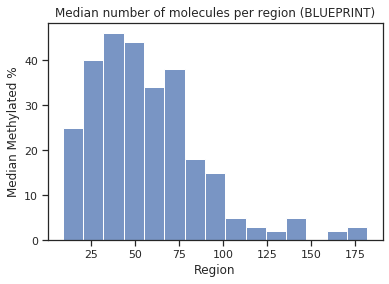

In [105]:
grouped = data.groupby('region_id')['number_molecules'] \
            .median() \
            .sort_values(ascending=False) \
            .reset_index()

sns.histplot(data=grouped, x='number_molecules')
plt.title('Median number of molecules per region (BLUEPRINT)')
plt.xlabel('Region')
plt.ylabel('Median Methylated %')
plt.show()

In [99]:
data.shape

(35154, 14)

In [106]:
280*104

29120